In [32]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler
from utils.losses import MSE, MEE

In [33]:
''' FOR THE FIRST TIME
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]

sort_idx = np.argsort(raw_data[:,11]) ; raw_data = raw_data[sort_idx]
np.random.shuffle(raw_data)
input_data=raw_data[:,:-2]
input_labels=raw_data[:,-2:]

frac_test=0.15
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)
Test_dataset = np.column_stack((test_set,test_labels))
Data_dataset = np.column_stack((data,labels))
np.savetxt('../../data/Test_set.txt',Test_dataset) ; np.savetxt('../../data/Data_set.txt',Data_dataset)
'''
raw_data = np.loadtxt("../../data/Data_set.txt")
data_scaler = StandardScaler() ; labels_scaler = StandardScaler()
raw_data[:,:-2] = data_scaler.fit_transform(raw_data[:,:-2]) 
raw_data[:,-2:] = labels_scaler.fit_transform(raw_data[:,-2:])

#splitting the data from the labels
data=raw_data[:,:-2]
labels=raw_data[:,-2:]

In [34]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [35]:
list_lamb = np.logspace(-7,-5,5)  ; print(list_lamb)

[1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05]


In [36]:
import utils.grid_search
importlib.reload(utils.grid_search)
from utils.grid_search import grid_search

# Structure to test: 
n_feat = np.shape(labels)[1]
#model1 = {'structure':[10, n_feat], 'func':['tanh', 'linear'], 'starting_points': xavier([10, n_feat])}
model1 = {'structure':[20, n_feat], 'func':['tanh', 'linear'], 'starting_points': xavier([20, n_feat])}
model2 = {'structure':[5,5,n_feat], 'func':['tanh','tanh','linear'], 'starting_points': xavier([5,5, n_feat])}
model3 = {'structure':[10,10,n_feat], 'func':['tanh','tanh','linear'],'starting_points': xavier([10,10,n_feat])}
#model5 = {'structure':[10,5,n_feat], 'func':['tanh','tanh','linear'],'starting_points': xavier([10,5,n_feat])}
#model6 = {'structure':[10,10,n_feat], 'func':['tanh','tanh','linear'],'starting_points': xavier([10,10,n_feat])}

models = [model1, model2, model3]#, model5, model6]
dict_models = {f'Model{i}': m for i, m in enumerate(models)} 

list_eta = [8e-5]
list_alpha = np.arange(0.1,0.3,0.1)
list_lamb = np.logspace(-6,-5,4) ; list_beta = np.arange(0.7,0.9,0.1)
dict_params = {'eta':list_eta, 'alpha':list_alpha, 'lamb':list_lamb, 'epoch':[10000], 
                'RMSProp' : [True], 'nesterov' : [True] , 'beta' : list_beta , 'verbose' : [False], 'batch_size' : [50], 'error_threshold' : [0] ,'patience' : [400]}

grid_results = grid_search(MLP_w, dict_models, dict_params, 
                           data, labels, MEE, n_jobs = 3,
                           verbose = 1, kind = 'k_fold', k = 4)

start training 225 possible combinations


KeyboardInterrupt: 

In [ ]:
grid_results[0]
#np.savetxt('../../data/sigmoid_search.txt',grid_results[1:10])

{'train': {'eta': 0.01,
  'alpha': 1.0,
  'lamb': 0.0,
  'epoch': 1000,
  'RMSProp': True,
  'nesterov': False,
  'beta': 0.8999999999999999,
  'verbose': False},
 'model': {'structure': [10, 2],
  'func': ['sigmoid', 'linear'],
  'starting_points': [0.5, 0.5]},
 'model_name': 'Model0',
 'Error': 0.27802162235711225}

In [ ]:
 Comment after the grid search is ended
import json

with open('grid_search2.json','w') as fp:
    json.dump(grid_results,fp) 


In [ ]:
#loading dictionary grid_search
with open('../report/tanh_search.json') as json_file:
    grid_results = json.load(json_file)

In [ ]:
frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                               frac_training=frac_training)
best_model_dict = grid_results[0]
best_model_dict['model']
best_model = MLP(**best_model_dict['model'])
train_dict = dict(best_model_dict['train'])
#del train_dict['n_candidate']
#del train_dict['test_more_init']

In [ ]:
best_model.train(input_data, train_labels, val_data, val_labels, **train_dict)

In [ ]:
def plot_results(network, input_data, val_data, labels, val_labels):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()

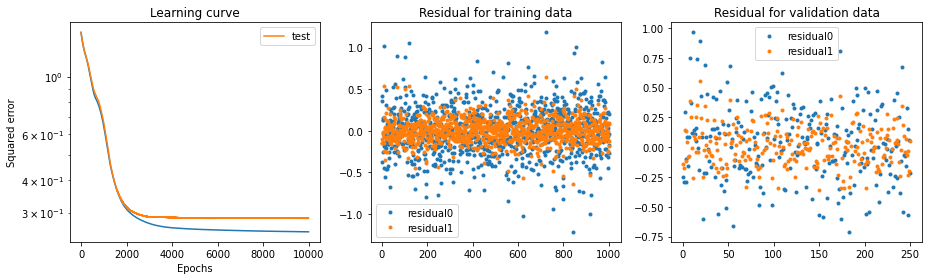

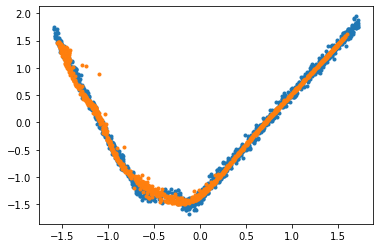

In [ ]:
plot_results(best_model, input_data, val_data, train_labels, val_labels)
pred = best_model.predict(data)
plt.plot(labels[:,1],labels[:,0],".")
plt.plot(pred[:,1],pred[:,0],".")


## Testing PARALLEL

In [ ]:
import utils.grid_search
importlib.reload(utils.grid_search)
from utils.grid_search import grid_search

# Structure to test: 
n_feat = np.shape(labels)[1]
model1 = {'structure':[10, n_feat], 'func':['sigmoid', 'linear'], 'starting_points': [0.5]*2}
model2 = {'structure':[15, n_feat], 'func':['sigmoid', 'linear'], 'starting_points': [0.5]*2}
model3 = {'structure':[20, n_feat], 'func':['sigmoid', 'linear'], 'starting_points': [0.5]*2}
#model5= {'structure':[4,4, n_feat], 'func':['sigmoid','sigmoid','linear'], 'starting_points': [0.5]*2}
#model4 = {'structure':[5,4,n_feat], 'func':['sigmoid','sigmoid','linear'],'starting_points': [0.5]*2}
#model6 = {'structure':[6,6,n_feat], 'func':['sigmoid','sigmoid','linear'],'starting_points': [0.5]*2}
models = [model1, model2, ]#model3, model4, model5, model6]
dict_models = {f'Model{i}': m for i, m in enumerate(models)} 

list_eta = [1e-2,5e-3]
list_alpha = [0., 1.]#np.arange(0,1, 0.5)
list_lamb = [0.] # np.arange(0,1,0.5)
list_beta = np.arange(0.6, 1, 0.1)

dict_params = {'eta':list_eta, 'alpha':list_alpha, 'lamb':list_lamb, 'epoch':[1000], 
               'RMSProp' : [True], 'nesterov' : [False] , 'beta' : list_beta, 'verbose': [False] }

grid_results = grid_search(MLP_w, dict_models, dict_params, 
                           data, labels, MEE,
                           n_jobs = -1,
                           verbose = 1, kind = 'hold_out')

start training 32 possible combinations
[trained=32] [elaps t=82.5 s] [remain t =0.0 s]]
Time for the grid search: 82.51737546920776 s


In [ ]:
grid_results

[{'train': {'eta': 0.01,
   'alpha': 1.0,
   'lamb': 0.0,
   'epoch': 1000,
   'RMSProp': True,
   'nesterov': False,
   'beta': 0.8999999999999999,
   'verbose': False},
  'model': {'structure': [10, 2],
   'func': ['sigmoid', 'linear'],
   'starting_points': [0.5, 0.5]},
  'model_name': 'Model0',
  'Error': 0.27802162235711225},
 {'train': {'eta': 0.01,
   'alpha': 0.0,
   'lamb': 0.0,
   'epoch': 1000,
   'RMSProp': True,
   'nesterov': False,
   'beta': 0.7,
   'verbose': False},
  'model': {'structure': [10, 2],
   'func': ['sigmoid', 'linear'],
   'starting_points': [0.5, 0.5]},
  'model_name': 'Model0',
  'Error': 0.27883056040215737},
 {'train': {'eta': 0.01,
   'alpha': 0.0,
   'lamb': 0.0,
   'epoch': 1000,
   'RMSProp': True,
   'nesterov': False,
   'beta': 0.7999999999999999,
   'verbose': False},
  'model': {'structure': [15, 2],
   'func': ['sigmoid', 'linear'],
   'starting_points': [0.5, 0.5]},
  'model_name': 'Model1',
  'Error': 0.2820319018353832},
 {'train': {'eta'